AETrainer.py


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

class AE(nn.Module):
    def __init__(self, architecture: dict, input_dim: int):
        super(AE, self).__init__()
        self.architecture = architecture

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, self.architecture["hidden_dim1"]),
            nn.ReLU(),
            nn.Linear(self.architecture["hidden_dim1"], self.architecture["hidden_dim2"]),
            nn.ReLU(),
            nn.Linear(self.architecture["hidden_dim2"], self.architecture["hidden_dim3"]),
            nn.ReLU(),
            nn.Linear(self.architecture["hidden_dim3"], self.architecture["output_dim"]),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.architecture["output_dim"], self.architecture["hidden_dim3"]),
            nn.ReLU(),
            nn.Linear(self.architecture["hidden_dim3"], self.architecture["hidden_dim2"]),
            nn.ReLU(),
            nn.Linear(self.architecture["hidden_dim2"], self.architecture["hidden_dim1"]),
            nn.ReLU(),
            nn.Linear(self.architecture["hidden_dim1"], input_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x) # 编码
        x = self.decoder(x) # 解码
        return x


class AETrainer:
    def __init__(self, config: dict, device: torch.device):
        """

        Args:
            config (dict):          the configuration dictionary
            device (torch.device):  the device to train on
        """
        self.device = device
        self.ae_config = config["ae"]
        self.lr = self.ae_config["lr"]
        self.epochs = self.ae_config["epochs"]
        self.lr_decay = self.ae_config["lr_decay"]
        self.patience = self.ae_config["patience"]
        self.n_samples = self.ae_config["n_samples"]
        self.batch_size = self.ae_config["batch_size"]
        self.architecture = self.ae_config["architecture"]
        self.weights_path = "./weights/ae_weights.pth"

    def train(self, X: torch.Tensor) -> AE:
        """
        This function trains the autoencoder on the given data.

        Args:
            X (torch.Tensor):   the data to train on

        Returns:
            AE: the trained autoencoder

        """
        self.X = X.view(X.size(0), -1)
        self.criterion = nn.MSELoss() # 定义损失使用均方误差
        self.ae_net = AE(self.architecture, input_dim=self.X.shape[1]).to(self.device)
        self.optimizer = optim.Adam(self.ae_net.parameters(), lr=self.lr)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,  # 学习率优化
                                                              mode="min",
                                                              factor=self.lr_decay,
                                                              patience=self.patience)

        if os.path.exists(self.weights_path):
            self.ae_net.load_state_dict(torch.load(self.weights_path))
            return self.ae_net

        train_loader, valid_loader = self._get_data_loader()

        print("Training Autoencoder:")
        for epoch in range(self.epochs):
            train_loss = 0.0
            for batch_x in train_loader:
                batch_x = batch_x.to(self.device)
                batch_x = batch_x.view(batch_x.size(0), -1)
                self.optimizer.zero_grad()
                output = self.ae_net(batch_x)
                loss = self.criterion(output, batch_x)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)
            valid_loss = self.validate(valid_loader)
            self.scheduler.step(valid_loss)
            current_lr = self.optimizer.param_groups[0]["lr"]

            if current_lr <= self.ae_config["min_lr"]: break
            print("Epoch: {}/{}, Train Loss: {:.4f}, Valid Loss: {:.4f}, LR: {:.6f}".
            format(epoch + 1, self.epochs, train_loss, valid_loss, current_lr))

        torch.save(self.ae_net.state_dict(), self.weights_path)
        return self.ae_net

    def validate(self, valid_loader: DataLoader) -> float:
        """
        This function validates the autoencoder on the given data during the training process.

        Args:
            valid_loader (DataLoader):  the data to validate on

        Returns:
            float: the validation loss
        """

        self.ae_net.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch_x in valid_loader:
                batch_x = batch_x.to(self.device)
                batch_x = batch_x.view(batch_x.size(0), -1)
                output = self.ae_net(batch_x)
                loss = self.criterion(output, batch_x)
                valid_loss += loss.item()
        valid_loss /= len(valid_loader)
        return valid_loss

    def embed(self, X: torch.Tensor) -> torch.Tensor:
        """
        This function embeds the given data using the trained autoencoder.

        Args:
            X (torch.Tensor):  the data to embed

        Returns:
            torch.Tensor: the embedded data
        """

        print("Embedding data ...")
        self.ae_net.eval()
        with torch.no_grad():
            X = X.view(X.size(0), -1)
            encoded_data = self.ae_net.encoder(X.to(self.device))
        return encoded_data

    def _get_data_loader(self) -> tuple:
        """
        This function splits the data into train and validation sets
        and returns the corresponding data loaders.

        Returns:
            tuple: the train and validation data loaders
        """

        X = self.X[:self.n_samples]
        trainset_len = int(len(X) * 0.9)
        validset_len = len(X) - trainset_len
        trainset, validset = random_split(X, [trainset_len, validset_len])
        train_loader = DataLoader(trainset, batch_size=self.ae_config["batch_size"], shuffle=True)
        valid_loader = DataLoader(validset, batch_size=self.ae_config["batch_size"], shuffle=False)
        return train_loader, valid_loader


# Finish Point
print("load AEtrianer.py successfuully!")

load AEtrianer.py successfuully!


data.py

In [47]:
import h5py
import torch
import numpy as np

from sklearn.datasets import make_moons
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.io import loadmat


def load_mnist() -> tuple:
    tensor_transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(root='../data',
                                train=True,
                                download=True,
                                transform=tensor_transform)
    test_set = datasets.MNIST(root='../data',
                                train=False,
                                download=True,
                                transform=tensor_transform)

    x_train, y_train = zip(*train_set)
    x_train, y_train = torch.cat(x_train), torch.Tensor(y_train)
    x_test, y_test = zip(*test_set)
    x_test, y_test = torch.cat(x_test), torch.Tensor(y_test)

    return x_train, y_train, x_test, y_test

def load_twomoon() -> tuple:
        data, y = make_moons(n_samples=7000, shuffle=True, noise=0.075, random_state=None)
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)
        x_train, x_test = torch.Tensor(x_train), torch.Tensor(x_test)
        y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)
        return x_train, y_train, x_test, y_test

def load_reuters() -> tuple:
    with h5py.File('../data/Reuters/reutersidf_total.h5', 'r') as f:
        x = np.asarray(f.get('data'), dtype='float32')
        y = np.asarray(f.get('labels'), dtype='float32')

        n_train = int(0.9 * len(x))
        x_train, x_test = x[:n_train], x[n_train:]
        y_train, y_test = y[:n_train], y[n_train:]

    x_train, x_test = torch.from_numpy(x_train), torch.from_numpy(x_test)
    y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

    return x_train, y_train, x_test, y_test

def load_smalldata() -> tuple:
    mat = loadmat('../data/uci/D153.mat')
    x = mat['data']
#    x = preprocessing.minmax_scale(x,axis=1)
#    x[np.isnan(x)] = 0
    y = mat['labels']
    y = y.reshape(-1)
    n_train = int(0.9 * len(x))
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]
    x_train, x_test = torch.Tensor(x_train), torch.Tensor(x_test)
    y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)
    # scaler = StandardScaler()
    # data = scaler.fit_transform(data)
    # x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42)
    # x_train, x_test = torch.Tensor(x_train), torch.Tensor(x_test)
    # y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)
    return x_train, y_train, x_test, y_test

def load_from_path(dpath: str, lpath: str = None) -> tuple:
    X = np.loadtxt(dpath, delimiter=',', dtype=np.float32)
    n_train = int(0.9 * len(X))

    x_train, x_test = X[:n_train], X[n_train:]
    x_train, x_test = torch.from_numpy(x_train), torch.from_numpy(x_test)

    if lpath is not None:
        y = np.loadtxt(lpath, delimiter=',', dtype=np.float32)
        y_train, y_test = y[:n_train], y[n_train:]
        y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

    else:
        y_train, y_test = None, None


    return x_train, y_train, x_test, y_test

def load_data(dataset: str) -> tuple:
    """
    This function loads the dataset specified in the config file.


    Args:
        dataset (str or dictionary):    In case you want to load your own dataset,
                                        you should specify the path to the data (and label if applicable)
                                        files in the config file in a dictionary fashion under the key "dataset".

    Raises:
        ValueError: If the dataset is not found in the config file.

    Returns:
        tuple: A tuple containing the train and test data and labels.
    """

    if dataset == 'mnist':
        x_train, y_train, x_test, y_test = load_mnist()
    elif dataset == 'twomoons':
        x_train, y_train, x_test, y_test = load_twomoon()
    elif dataset == 'reuters':
        x_train, y_train, x_test, y_test = load_reuters()
    elif dataset == 'smalldata':
        x_train, y_train, x_test, y_test = load_smalldata()
    else:
        try:
            data_path = dataset["dpath"]
            if "lpath" in dataset:
                label_path = dataset["lpath"]
            else:
                label_path = None
        except:
            raise ValueError("Could not find dataset path. Check your config file.")
        x_train, y_train, x_test, y_test = load_from_path(data_path, label_path)

    return x_train, x_test, y_train, y_test



# Finish Point
print("load data.py successfuully!")

load data.py successfuully!


metrics.py

In [39]:
import numpy as np
import sklearn.metrics as metrics

from evaluation import cluster_accuracy as acc1
from utils import *
from munkres import Munkres
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import jaccard_score as jaccard
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import fowlkes_mallows_score as fm
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

class Metrics:
    @staticmethod
    def acc_score(cluster_assignments: np.ndarray, y: np.ndarray, n_clusters: int)  -> float:
        """
        Computes the accuracy score of the clustering algorithm
        Args:
            cluster_assignments (np.ndarray):   cluster assignments for each data point
            y (np.ndarray):                     ground truth labels
            n_clusters (int):                   number of clusters

        Returns:
            float: accuracy score
        """

        confusion_matrix = metrics.confusion_matrix(y, cluster_assignments, labels=None)
        cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters=n_clusters)
        indices = Munkres().compute(cost_matrix)
        kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)
        y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
        print(metrics.confusion_matrix(y, y_pred))
        accuracy = np.mean(y_pred == y)
        return accuracy

    @staticmethod
    def nmi_score(cluster_assignments: np.ndarray, y: np.ndarray) -> float:
        """
        Computes the normalized mutual information score of the clustering algorithm
        Args:
            cluster_assignments (np.ndarray):   cluster assignments for each data point
            y (np.ndarray):                     ground truth labels

        Returns:
            float: normalized mutual information score
        """
        return nmi(cluster_assignments, y)

    @staticmethod
    def Jaccard_index(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
        return jaccard(true_labels, cluster_labels, average='macro')

    @staticmethod
    def ARI_score(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
        return ari(true_labels, cluster_labels)

    @staticmethod
    def FM_score(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
        return fm(true_labels, cluster_labels)

    @staticmethod
    def sil_score(origin_data: np.ndarray, cluster_labels: np.ndarray) -> float:
        return silhouette_score(origin_data, cluster_labels)

    @staticmethod
    def c_h_score(origin_data: np.ndarray, cluster_labels: np.ndarray) -> float:
        return calinski_harabasz_score(origin_data, cluster_labels)

    @staticmethod
    def d_b_score(origin_data: np.ndarray, cluster_labels: np.ndarray) -> float:
        return davies_bouldin_score(origin_data, cluster_labels)

    @staticmethod
    def e_acc(origin_data: np.ndarray, cluster_labels: np.ndarray)  -> float:
        return acc1(origin_data, cluster_labels)


# Finish Point
print("load metrics.py successfuully!")

load metrics.py successfuully!


SiameseTrainer.py

In [40]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from annoy import AnnoyIndex
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader, random_split


class SiameseNet(nn.Module):
    def __init__(self, architecture: dict, input_dim: int):
        super(SiameseNet, self).__init__()
        self.architecture = architecture
        self.num_of_layers = self.architecture["n_layers"]
        self.layers = nn.ModuleList()

        current_dim = input_dim
        for layer, dim in self.architecture.items():
            if layer == "n_layers":
                continue
            next_dim = dim
            layer = nn.Sequential(nn.Linear(current_dim, next_dim), nn.ReLU())
            self.layers.append(layer)
            current_dim = next_dim

    def forward_once(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)  # 24行，前向传播
        return x

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> tuple:
        output1 = self.forward_once(x1) # 网络1
        output2 = self.forward_once(x2) # 网络2，两者共用一个权重
        return output1, output2


class SiameseDataset:
    def __init__(self, pairs: list):
        """
        Args:
            pairs (list):  A list of tuples containing the
                           pairs of data and their labels
        """
        self.pairs = pairs

    def __getitem__(self, index: int):
        x1 = self.pairs[index][0]
        x2 = self.pairs[index][1]
        label = self.pairs[index][2]
        return x1, x2, label

    def __len__(self):
        return len(self.pairs)


class ContrastiveLoss(nn.Module):
    def __init__(self, margin: float = 1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1: torch.Tensor, output2: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
        """

        Args:
            output1 (torch.Tensor):     First output of the siamese network
            output2 (torch.Tensor):     Second output of the siamese network
            label (torch.Tensor):       Should be 1 if the two outputs are similar
                                        and 0 if they are not

        Returns:
            torch.Tensor: loss value
        """

        euclidean = nn.functional.pairwise_distance(output1, output2) # 计算两个输出的距离
        positive_distance = torch.pow(euclidean, 2) # 正对：距离平方
        negative_distance = torch.pow(torch.clamp(self.margin - euclidean, min=0.0), 2) # 负对
        loss = torch.mean((label * positive_distance) + ((1 - label) * negative_distance))
        return loss


class SiameseTrainer:
    def __init__(self, config: dict, device: torch.device):
        """
        Args:
            config (dict):          A dictionary containing the configuration
            device (torch.device):  The device to be used for training
        """

        self.device = device
        self.siamese_config = config["siamese"]
        self.lr = self.siamese_config["lr"]
        self.epochs = self.siamese_config["epochs"]
        self.lr_decay = self.siamese_config["lr_decay"]
        self.patience = self.siamese_config["patience"]
        self.batch_size = self.siamese_config["batch_size"]
        self.architecture = self.siamese_config["architecture"]
        self.weights_path = "./weights/siamese_weights.pth"

    def train(self, X: torch.Tensor) -> SiameseNet:
        """
        Trains the siamese network

        Args:
            X (torch.Tensor):  The data to be used for training

        Returns:
            SiameseNet: The trained siamese network
        """

        self.X = X.view(X.size(0), -1)
        # self.X = X

        self.criterion = ContrastiveLoss()
        self.siamese_net = SiameseNet(self.architecture, input_dim=self.X.shape[1]).to(self.device)
        self.optimizer = optim.Adam(self.siamese_net.parameters(), lr=self.lr)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                              mode="min",
                                                              factor=self.lr_decay,
                                                              patience=self.patience)

        if os.path.exists(self.weights_path):
            self.siamese_net.load_state_dict(torch.load(self.weights_path))
            return self.siamese_net

        train_loader, valid_loader = self._get_data_loader()

        print("Training Siamese Network:")
        self.siamese_net.train()
        for epoch in range(self.epochs):
            train_loss = 0.0
            for x1, x2, label in train_loader:
                x1 = x1.to(self.device)
                x1 = x1.view(x1.size(0), -1)
                x2 = x2.to(self.device)
                x2 = x2.view(x2.size(0), -1)
                label = label.to(self.device)
                self.optimizer.zero_grad()
                output1, output2 = self.siamese_net(x1, x2)
                loss = self.criterion(output1, output2, label)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()


            train_loss /= len(train_loader)
            valid_loss = self.validate(valid_loader)
            self.scheduler.step(valid_loss)
            current_lr = self.optimizer.param_groups[0]["lr"]

            if current_lr <= self.siamese_config["min_lr"]:
                break
            print("Epoch: {}/{}, Train Loss: {:.4f}, Valid Loss: {:.4f}, LR: {:.6f}".
            format(epoch + 1, self.epochs, train_loss, valid_loss, current_lr))

        torch.save(self.siamese_net.state_dict(), self.weights_path)
        return self.siamese_net

    def validate(self, valid_loader: DataLoader) -> float:
        """
        Validates the siamese network

        Args:
            valid_loader (DataLoader):  The dataloader for the validation data

        Returns:
            float:  The validation loss
        """

        valid_loss = 0.0
        self.siamese_net.eval()
        with torch.no_grad():
            for x1, x2, label in valid_loader:
                x1 = x1.to(self.device)
                x1 = x1.view(x1.size(0), -1)
                x2 = x2.to(self.device)
                x2 = x2.view(x2.size(0), -1)
                label = label.to(self.device)
                output1, output2 = self.siamese_net(x1, x2)
                loss = self.criterion(output1, output2, label)
                valid_loss += loss.item()
        valid_loss /= len(valid_loader)
        return valid_loss

    def _get_knn_pairs(self) -> list:
        """
        Gets the pairs of data points to be used for training the siamese network.
        The pairs are chosen such that each data point has n_neighbors positive pairs
        and n_neighbors negative pairs where the neighbors are chosen using KNN

        Returns:
            list:   A list of pairs of data points
        """

        pairs = []
        X = self.X.detach().cpu().numpy()
        data_indices = np.arange(len(X))
        n_neighbors = self.siamese_config["n_neighbors"]
        nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm="ball_tree").fit(X) # nbrs包括所有点的近邻的索引和距离
        _, neighbors_indices = nbrs.kneighbors(X) # 索引

        for i in range(len(X)):
            non_neighbors_indices = np.delete(data_indices, neighbors_indices[i]) # 非近邻索引
            # 随机选择相同数量的非近邻的索引
            non_neighbors_random_chosen_indices = np.random.choice(non_neighbors_indices, n_neighbors)

            positive_pairs = [[self.X[i], self.X[n], 1] for n in neighbors_indices[i][1:n_neighbors + 1]] # 构造正对，n从索引中获得
            negative_pairs = [[self.X[i], self.X[n], 0] for n in non_neighbors_random_chosen_indices]

            pairs += positive_pairs
            pairs += negative_pairs

        return pairs

    def _get_approx_nn_pairs(self) -> list:
        """
        Gets the pairs of data points to be used for training the siamese network.
        The pairs are chosen such that each data point has 1 neighbor from its nearest n_neighbors
        neighbors and 1 neighbor from the rest of the data points. The neighbors are chosen using
        approximate nearest neighbors using Annoy library.

        Returns:
            list:  A list of pairs of data points
        """

        pairs = []
        n_samples = self.siamese_config["n_samples"]
        n_neighbors = self.siamese_config["n_neighbors"]
        indices = torch.randperm(self.X.shape[0])[:n_samples]
        x_train = self.X[indices]
        X_numpy = self.X[indices].detach().cpu().numpy()
        data_indices = np.arange(len(x_train))

        ann = AnnoyIndex(X_numpy.shape[1], 'euclidean')
        for i, x_ in enumerate(X_numpy):
            ann.add_item(i, x_)
        ann.build(50)

        neighbors_indices = np.empty((len(X_numpy), n_neighbors + 1))
        for i in range(len(X_numpy)):
            nn_i = ann.get_nns_by_item(i, n_neighbors + 1, include_distances=False)
            neighbors_indices[i, :] = np.array(nn_i)
        neighbors_indices = neighbors_indices.astype(int)

        print("Building dataset for the siamese network ...")
        for i in range(len(X_numpy)):
            non_neighbors_indices = np.delete(data_indices, neighbors_indices[i])

            neighbor_idx = np.random.choice(neighbors_indices[i][1:], 1)
            non_nbr_idx = np.random.choice(non_neighbors_indices, 1)

            positive_pairs = [[x_train[i], x_train[neighbor_idx], 1]]
            negative_pairs = [[x_train[i], x_train[non_nbr_idx], 0]]

            pairs += positive_pairs
            pairs += negative_pairs

        return pairs

    def _get_pairs(self) -> list:
        """
        Gets the pairs of data points to be used for training the siamese network

        Returns:
            list: A list of pairs of data points
        """

        should_use_approx = self.siamese_config["use_approx"]
        if should_use_approx:
            return self._get_approx_nn_pairs()
        else:
            return self._get_knn_pairs()

    def _get_data_loader(self) -> tuple:
        """
        This function splits the data into train and validation sets
        and returns the corresponding data loaders.

        Returns:
            tuple: A tuple containing the train and validation data loaders
        """

        pairs = self._get_pairs()
        siamese_dataset = SiameseDataset(pairs)
        siamese_trainset_len = int(len(siamese_dataset) * 0.9)
        siamese_validset_len = len(siamese_dataset) - siamese_trainset_len
        siamese_trainset, siamese_validset = random_split(siamese_dataset, [siamese_trainset_len, siamese_validset_len])
        siamese_trainloader = DataLoader(siamese_trainset, batch_size=self.siamese_config["batch_size"], shuffle=True)
        siamese_validloader = DataLoader(siamese_validset, batch_size=self.siamese_config["batch_size"], shuffle=False)
        return siamese_trainloader, siamese_validloader

    # 小批量优化
    def get_data_loader_myself(self) -> tuple:
        """
        This function splits the data into train and validation sets
        and returns the corresponding data loaders.

        Returns:
            tuple: A tuple containing the train and validation data loaders
        """
        # 构造正负对的时候就需要修改，构造循环取数据的DataLoader需要给定数目，所以在定义的时候记得记录下真实的数目
        # 先分好训练集和验证集，主要是分好数据点(保证验证集中的x不会出现在训练集中即可)
        # 所以需要第一个参数：总数据集的大小，不用传参
        X = self.X.detach().cpu().numpy()
        siamese_trainset_len = int(len(X) * 0.9)
        siamese_validset_len = len(X) - siamese_trainset_len
        siamese_trainset, siamese_validset = random_split(X, [siamese_trainset_len, siamese_validset_len])
        # 开始对训练集进行正负对小批量划分
        train_pairs = self.get_pairs_myself(siamese_trainset)
        siamese_train_dataset = SiameseDataset(train_pairs)
        number = 5 * self.siamese_config["batch_size"]
        siamese_trainloader = DataLoader(siamese_train_dataset, batch_size=number, shuffle=False)  # 打乱就没意义了
        # 开始对验证集进行正负对小批量划分
        valid_pairs = self.get_pairs_myself(siamese_validset)
        siamese_valid_dataset = SiameseDataset(valid_pairs)
        number = 5 * self.siamese_config["batch_size"]
        siamese_validloader = DataLoader(siamese_valid_dataset, batch_size=number, shuffle=False)
        return siamese_trainloader, siamese_validloader

    def get_pairs_myself(self , X) -> list:
        # 先随机取多个小批量，然后分别进行正负对的打包
        train_pairs = []
        # 取小批量同时记录
        m = self.siamese_config["batch_size"]
        train_loader = DataLoader(X, batch_size=m, shuffle=True)
        for data in train_loader:
            # 开始对data进行拆分:0~mid-1求正对，mid~m-1求负对
            data_pairs = self.get_knn_data_pairs(data)
            train_pairs += data_pairs
        return train_pairs

    def get_knn_data_pairs(self , X) -> list:
        pairs = []
        data_indices = np.arange(len(X))
        # n_neighbors = self.siamese_config["n_neighbors"]
        n_neighbors = 5
        nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm="ball_tree").fit(X) # nbrs包括所有点的近邻的索引和距离
        _, neighbors_indices = nbrs.kneighbors(X) # 索引

        for i in range(len(X)):
            if i < len(X)/2:
                positive_pairs = [[self.X[i], self.X[n], 1] for n in neighbors_indices[i][1:n_neighbors + 1]]
                pairs += positive_pairs
            else:
                non_neighbors_indices = np.delete(data_indices, neighbors_indices[i]) # 非近邻索引
                non_neighbors_random_chosen_indices = np.random.choice(non_neighbors_indices, n_neighbors)
                negative_pairs = [[self.X[i], self.X[n], 0] for n in non_neighbors_random_chosen_indices]
                pairs += negative_pairs
        return pairs





# Finish Point
print("load SiameseTrainer.py successfuully!")

load SiameseTrainer.py successfuully!


SpectralTrainer.py

In [41]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from utils import *
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, random_split, TensorDataset



class SpectralNetModel(nn.Module):
    def __init__(self, architecture: dict, input_dim: int):
        super(SpectralNetModel, self).__init__()
        self.architecture = architecture
        self.num_of_layers = self.architecture["n_layers"]
        self.layers = nn.ModuleList()
        self.input_dim = input_dim

        current_dim = self.input_dim
        for layer, dim in self.architecture.items():
            next_dim = dim
            if layer == "n_layers":
                continue
            if layer == "output_dim":
                layer = nn.Sequential(nn.Linear(current_dim, next_dim), nn.Tanh())
                self.layers.append(layer)
            else:
                layer = nn.Sequential(nn.Linear(current_dim, next_dim), nn.ReLU())
                self.layers.append(layer)
                current_dim = next_dim


    def forward(self, x: torch.Tensor, is_orthonorm: bool = True) -> torch.Tensor:
        """
        This function performs the forward pass of the model.
        If is_orthonorm is True, the output of the network is orthonormalized
        using the Cholesky decomposition.

        Args:
            x (torch.Tensor):               The input tensor
            is_orthonorm (bool, optional):  Whether to orthonormalize the output or not.
                                            Defaults to True.

        Returns:
            torch.Tensor: The output tensor
        """

        for layer in self.layers:
            x = layer(x)

        Y_tilde = x
        if is_orthonorm:
            m = Y_tilde.shape[0]
            to_factorize = torch.mm(Y_tilde.t(), Y_tilde)
            L = torch.linalg.cholesky(to_factorize, upper=False)
            L_inverse = torch.inverse(L)
            self.orthonorm_weights = np.sqrt(m) * L_inverse.t()

        Y = torch.mm(Y_tilde, self.orthonorm_weights)
        return Y



class SpectralNetLoss(nn.Module):
    def __init__(self):
        super(SpectralNetLoss, self).__init__()

    def forward(self, W: torch.Tensor, Y: torch.Tensor , is_normalized: bool = False) -> torch.Tensor:
        """
        This function computes the loss of the SpectralNet model.
        The loss is the rayleigh quotient of the Laplacian matrix obtained from W,
        and the orthonormalized output of the network.

        Args:
            W (torch.Tensor):               Affinity matrix
            Y (torch.Tensor):               Output of the network
            is_normalized (bool, optional): Whether to use the normalized Laplacian matrix or not.

        Returns:
            torch.Tensor: The loss
        """
        m = Y.size(0)
        if is_normalized:
            D = torch.sum(W, dim=1)
            Y = Y / D[:, None]

        Dy = torch.cdist(Y, Y)
        loss = torch.sum(W * Dy.pow(2)) / (2 * m)

        return loss


class SpectralTrainer:
    def __init__(self, config: dict, device: torch.device, is_sparse: bool = False):
        """
        This class is responsible for training the SpectralNet model.

        Args:
            config (dict):                  The configuration dictionary
            device (torch.device):          The device to use for training
            is_sparse (bool, optional):     Whether the graph-laplacian obtained from a mini-batch is sparse or not.
                                            In case it is sparse, we build the batch by taking 1/5 of the original random batch,
                                            and then we add to each sample 4 of its nearest neighbors. Defaults to False.
        """

        self.device = device
        self.is_sparse = is_sparse
        self.spectral_config = config["spectral"]

        self.lr = self.spectral_config["lr"]
        self.epochs = self.spectral_config["epochs"]
        self.lr_decay = self.spectral_config["lr_decay"]
        self.patience = self.spectral_config["patience"]
        self.batch_size = self.spectral_config["batch_size"]
        self.architecture = self.spectral_config["architecture"]

    def train(self, X: torch.Tensor, y: torch.Tensor, siamese_net: nn.Module = None) -> SpectralNetModel:
        """
        This function trains the SpectralNet model.

        Args:
            X (torch.Tensor):                       The dataset to train on
            y (torch.Tensor):                       The labels of the dataset in case there are any
            siamese_net (nn.Module, optional):      The siamese network to use for computing the affinity matrix.

        Returns:
            SpectralNetModel: The trained SpectralNet model
        """

        self.X = X.view(X.size(0), -1)
        self.y = y
        self.counter = 0
        self.siamese_net = siamese_net
        self.criterion = SpectralNetLoss()
        self.spectral_net = SpectralNetModel(self.architecture, input_dim=self.X.shape[1]).to(self.device)
        self.optimizer = optim.Adam(self.spectral_net.parameters(), lr=self.lr)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                              mode='min',
                                                              factor=self.lr_decay,
                                                              patience=self.patience)


        train_loader, ortho_loader, valid_loader = self._get_data_loader()

        print("Training SpectralNet:")
        for epoch in range(self.epochs):
            train_loss = 0.0
            for (X_grad, y_grad), (X_orth, _) in zip(train_loader, ortho_loader):
                X_grad = X_grad.to(device=self.device)
                X_grad = X_grad.view(X_grad.size(0), -1)
                X_orth = X_orth.to(device=self.device)
                X_orth = X_orth.view(X_orth.size(0), -1)

                if self.is_sparse:
                    X_grad = make_batch_for_sparse_grapsh(X_grad)
                    X_orth = make_batch_for_sparse_grapsh(X_orth)

                # Orthogonalization step
                self.spectral_net.eval()
                self.spectral_net(X_orth, is_orthonorm=True)

                # Gradient step
                self.spectral_net.train()
                self.optimizer.zero_grad()

                if self.is_sparse:
                    X_grad = make_batch_for_sparse_grapsh(X_grad)

                Y = self.spectral_net(X_grad, is_orthonorm=False)
                if self.siamese_net is not None:
                    with torch.no_grad():
                        X_grad = self.siamese_net.forward_once(X_grad)

                W = self._get_affinity_matrix(X_grad)

                loss = self.criterion(W, Y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)

            # Validation step
            valid_loss = self.validate(valid_loader)
            self.scheduler.step(valid_loss)

            current_lr = self.optimizer.param_groups[0]["lr"]
            if current_lr <= self.spectral_config["min_lr"]: break
            print("Epoch: {}/{}, Train Loss: {:.7f}, Valid Loss: {:.7f}, LR: {:.6f}".
            format(epoch + 1, self.epochs, train_loss, valid_loss, current_lr))

        return self.spectral_net

    def validate(self, valid_loader: DataLoader) -> float:
        """
        This function validates the SpectralNet model during the training process.

        Args:
            valid_loader (DataLoader):  The validation data loader

        Returns:
            float: The validation loss
        """

        valid_loss = 0.0
        self.spectral_net.eval()
        with torch.no_grad():
            for batch in valid_loader:
                X, y = batch
                X, y = X.to(self.device), y.to(self.device)

                if self.is_sparse:
                    X = make_batch_for_sparse_grapsh(X)

                Y = self.spectral_net(X, is_orthonorm=False)
                with torch.no_grad():
                    if self.siamese_net is not None:
                        X = self.siamese_net.forward_once(X)

                W = self._get_affinity_matrix(X)

                loss = self.criterion(W, Y)
                valid_loss += loss.item()

        self.counter += 1

        valid_loss /= len(valid_loader)
        return valid_loss


    def _get_affinity_matrix(self, X: torch.Tensor) -> torch.Tensor:
        """
        This function computes the affinity matrix W using the Gaussian kernel.

        Args:
            X (torch.Tensor):   The input data

        Returns:
            torch.Tensor: The affinity matrix W
        """

        is_local = self.spectral_config["is_local_scale"]  # 局部/全局
        n_neighbors = self.spectral_config["n_neighbors"]
        scale_k = self.spectral_config["scale_k"]
        Dx = torch.cdist(X,X) # 距离
        Dis, indices = get_nearest_neighbors(X, k=n_neighbors + 1) # 点的k近邻的距离与索引
        scale = compute_scale(Dis, k=scale_k, is_local=is_local) # 计算高斯相似函数的尺度
        W = get_gaussian_kernel(Dx, scale, indices, device=self.device, is_local=is_local)
        return W


    def _get_data_loader(self) -> tuple:
        """
        This function returns the data loaders for training, validation and testing.

        Returns:
            tuple:  The data loaders
        """
        if self.y is None:
            self.y = torch.zeros(len(self.X))
        train_size = int(0.9 * len(self.X))
        valid_size = len(self.X) - train_size
        dataset = TensorDataset(self.X, self.y)
        train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        ortho_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False)
        return train_loader, ortho_loader, valid_loader



class ReduceLROnAvgLossPlateau(_LRScheduler):
    def __init__(self, optimizer, factor=0.1, patience=10, min_lr=0, verbose=False, min_delta=1e-4):
        """
        Custom ReduceLROnPlateau scheduler that uses the average loss instead of the loss of the last epoch.

        Args:
            optimizer (_type_):             The optimizer
            factor (float, optional):       factor by which the learning rate will be reduced.
                                            new_lr = lr * factor. Defaults to 0.1.
            patience (int, optional):       number of epochs with no average improvement after
                                            which learning rate will be reduced.
            min_lr (int, optional):         A lower bound on the learning rate of all param groups.
            verbose (bool, optional):       If True, prints a message to stdout for each update.
            min_delta (_type_, optional):   threshold for measuring the new optimum, to only focus on
                                            significant changes. Defaults to 1e-4.
        """

        self.factor = factor
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best = 1e5
        self.avg_losses = []
        self.min_lr = min_lr
        super(ReduceLROnAvgLossPlateau, self).__init__(optimizer)

    def get_lr(self):
        return [base_lr * self.factor ** self.num_bad_epochs
                for base_lr in self.base_lrs]

    def step(self, loss=1.0,  epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch


        current_loss = loss
        if len(self.avg_losses) < self.patience:
            self.avg_losses.append(current_loss)
        else:
            self.avg_losses.pop(0)
            self.avg_losses.append(current_loss)
        avg_loss = sum(self.avg_losses) / len(self.avg_losses)
        if avg_loss < self.best - self.min_delta:
            self.best = avg_loss
            self.wait = 0
        else:
            if self.wait >= self.patience:
                for param_group in self.optimizer.param_groups:
                    old_lr = float(param_group['lr'])
                    if old_lr > self.min_lr:
                        new_lr = old_lr * self.factor
                        new_lr = max(new_lr, self.min_lr)
                        param_group['lr'] = new_lr
                        if self.verbose:
                            print(f'Epoch {epoch}: reducing learning rate to {new_lr}.')
                self.wait = 0
            self.wait += 1


# Finish Point
print("load SpectralTrainer.py successfuully!")

load SpectralTrainer.py successfuully!


utils.py

In [42]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from annoy import AnnoyIndex
from sklearn.neighbors import NearestNeighbors



def get_number_of_clusters(X: torch.Tensor,  n_samples: int, threshold: float) -> int:
    """
    Computes the number of clusters in the given dataset

    Args:
        X:          dataset
        n_samples:  number of samples to use for computing the number of clusters
        threshold:  threshold for the eigenvalues of the laplacian matrix. This
                    threshold is used in order to find when the difference between
                    the eigenvalues becomes large.

    Returns:
        Number of clusters in the dataset
    """
    indices = torch.randperm(X.shape[0])[:n_samples]
    X = X[indices]

    W = get_affinity_matrix(X)
    L = get_laplacian(W)
    vals = get_eigenvalues(L)
    diffs = np.diff(vals)
    cutoff = np.argmax(diffs > threshold)
    num_clusters = cutoff + 1
    return num_clusters

def build_ann(X: torch.Tensor):
    """
    Builds approximate-nearest-neighbors object
    that can be used to calculate the knn of a data-point

    Args:
        X:  dataset
    """
    X = X.view(X.size(0), -1)
    t = AnnoyIndex(X[0].shape[0], 'euclidean')
    for i, x_i in enumerate(X):
        t.add_item(i, x_i)

    t.build(50)
    t.save('ann_index.ann')


def make_batch_for_sparse_grapsh(batch_x: torch.Tensor) -> torch.Tensor:
    """
    Computes new batch of data points from the given batch (batch_x)
    in case that the graph-laplacian obtained from the given batch is sparse.
    The new batch is computed based on the nearest neighbors of 0.25
    of the given batch

    Args:
        batch_x:    Batch of data points

    Returns:
        New batch of data points
    """

    batch_size = batch_x.shape[0]
    batch_size //= 5
    new_batch_x = batch_x[:batch_size]
    batch_x = new_batch_x
    n_neighbors = 5

    u = AnnoyIndex(batch_x[0].shape[0], 'euclidean')
    u.load('ann_index.ann')
    for x in batch_x:
        x = x.detach().cpu().numpy()
        nn_indices = u.get_nns_by_vector(x, n_neighbors)
        nn_tensors = [u.get_item_vector(i) for i in nn_indices[1:]]
        nn_tensors = torch.tensor(nn_tensors)
        new_batch_x = torch.cat((new_batch_x, nn_tensors))

    return new_batch_x


def get_laplacian(W: torch.Tensor) -> np.ndarray:
    """
    Computes the unnormalized Laplacian matrix, given the affinity matrix W

    Args:
        W (torch.Tensor):   Affinity matrix

    Returns:
        Laplacian matrix
    """

    W = W.detach().cpu().numpy()
    D = np.diag(W.sum(axis=1))
    L = D - W
    return L


def sort_laplacian(L: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Sorts the columns and the rows of the laplacian by the true lablel in order
    to see whether the sorted laplacian is a block diagonal matrix

    Args:
        L:  Laplacian matrix
        y:  labels

    Returns:
        Sorted laplacian
    """

    i = np.argsort(y)
    L = L[i, :]
    L = L[:, i]
    return L


def sort_matrix_rows(A: np.ndarray , y: np.ndarray) -> np.ndarray:
    """
    Sorts the rows of a matrix by a given order y

    Args:
        A:  Numpy ndarray
        y:  True labels
    """

    i = np.argsort(y)
    A = A[i, :]
    return A


def get_eigenvalues(A: np.ndarray) -> np.ndarray:
    """
    Computes the eigenvalues of a given matrix A and sorts them in increasing order

    Args:
        A:  Numpy ndarray

    Returns:
        Sorted eigenvalues
    """

    _, vals, _ = np.linalg.svd(A)
    sorted_vals = vals[np.argsort(vals)]
    return sorted_vals


def get_eigenvectors(A: np.ndarray) -> np.ndarray:
    """
    Computes the eigenvectors of a given matrix A and sorts them by the eigenvalues
    Args:
        A:  Numpy ndarray

    Returns:
        Sorted eigenvectors
    """

    vecs, vals, _ = np.linalg.svd(A)
    vecs = vecs[:, np.argsort(vals)]
    return vecs

def plot_eigenvalues(vals: np.ndarray):
    """
    Plot the eigenvalues of the laplacian

    Args:
        vals:   Eigenvalues
    """

    rang = range(len(vals))
    plt.plot(rang, vals)
    plt.show()

def get_laplacian_eigenvectors(V: torch.Tensor, y: np.ndarray) -> np.ndarray:
    """
    Returns eigenvectors of the laplacian when the data is in increasing order by the true label.
    i.e., the rows of the eigenvectors matrix V are sorted by the true labels in increasing order.

    Args:
        V:  Eigenvectors matrix
        y:  True labels
    """

    V = sort_matrix_rows(V, y)
    rang = range(len(y))
    return V, rang

def plot_laplacian_eigenvectors(V: np.ndarray, y: np.ndarray):
    """
    Plot the eigenvectors of the laplacian when the data is in increasing order by the true label.
    i.e., the rows of the eigenvectors matrix V are sorted by the true labels in increasing order.

    Args:
        V:  Eigenvectors matrix
        y:  True labels
    """

    # sort the rows of V
    V = sort_matrix_rows(V, y)
    rang = range(len(y))
    plt.plot(rang, V)
    plt.show()
    return plt


def plot_sorted_laplacian(W: torch.Tensor, y: np.ndarray):
    """
    Plot the block diagonal matrix that is obtained from the sorted laplacian

    Args:
        W:  Affinity matrix
        y:  True labels
    """
    L = get_laplacian(W)
    L = sort_laplacian(L, y)
    plt.imshow(L, cmap='hot', norm=colors.LogNorm())
    plt.imshow(L, cmap='flag')
    plt.show()


def get_nearest_neighbors(X: torch.Tensor, Y: torch.Tensor = None, k: int = 3) -> tuple[np.ndarray, np.ndarray]:
    """
    Computes the distances and the indices of the
    k nearest neighbors of each data point

    Args:
        X:              Batch of data points
        Y (optional):   Defaults to None.
        k:              Number of nearest neighbors to calculate. Defaults to 3.

    Returns:
        Distances and indices of each datapoint
    """

    if Y is None:
        Y = X
    if len(X) < k:
        k = len(X)
    X = X.cpu().detach().numpy()
    Y = Y.cpu().detach().numpy()
    nbrs = NearestNeighbors(n_neighbors=k).fit(Y)
    Dis, Ids = nbrs.kneighbors(X)
    return Dis, Ids


def get_grassman_distance(A: np.ndarray, B: np.ndarray) -> float:
    """
    Computes the Grassmann distance between the subspaces spanned by the columns of A and B

    Args:
        A:  Numpy ndarray
        B:  Numpy ndarray
    """

    M = np.dot(np.transpose(A), B)
    _, s, _ = np.linalg.svd(M, full_matrices=False)
    s = 1 - np.square(s)
    grassmann = np.sum(s)
    return grassmann


def compute_scale(Dis: np.ndarray, k: int = 2, med: bool = True, is_local: bool = True) -> np.ndarray:
    """
    Computes the scale for the Gaussian similarity function

    Args:
        Dis:        Distances of the k nearest neighbors of each data point.
        k:          Number of nearest neighbors. Defaults to 2.
        med:        Scale calculation method. Can be calculated by the median distance
                    from a data point to its neighbors, or by the maximum distance.
        is_local:   Local distance (different for each data point), or global distance. Defaults to local.

    Returns:
        scale (global or local)
    """

    if is_local:
        if not med:
            scale = np.max(Dis, axis=1) # 按列求最大值
        else:
            scale = np.median(Dis, axis=1) # 按列取中位数
    else:
        if not med:
            scale = np.max(Dis[:, k - 1]) # 第k-1列取最大
        else:
            scale = np.median(Dis[:, k - 1])
    return scale


def get_gaussian_kernel(D: torch.Tensor, scale, Ids: np.ndarray, device: torch.device, is_local: bool = True) -> torch.Tensor:
    """
    Computes the Gaussian similarity function
    according to a given distance matrix D and a given scale

    Args:
        D:      Distance matrix
        scale:  scale
        Ids:    Indices of the k nearest neighbors of each sample
        device: Defaults to torch.device("cpu")
        is_local:  Determines whether the given scale is global or local

    Returns:
        Matrix W with Gaussian similarities
    """

    if not is_local:
        # global scale
        W = torch.exp(-torch.pow(D, 2) / (scale ** 2))
    else:
        # local scales
        W = torch.exp(-torch.pow(D, 2).to(device) / (torch.tensor(scale).float().to(device).clamp_min(1e-7) ** 2))
    if Ids is not None:
        n, k = Ids.shape
        mask = torch.zeros([n, n]).to(device=device)
        for i in range(len(Ids)):
            mask[i, Ids[i]] = 1
        W = W * mask
    sym_W = (W + torch.t(W)) / 2. # 对称
    return sym_W


def plot_data_by_assignmets(X, assignments: np.ndarray):
    """
    Plots the data with the assignments obtained from SpectralNet.
    Relevant only for 2D data

    Args:
        X:                      Data
        cluster_assignments:    Cluster assignments
    """

    plt.scatter(X[:, 0], X[:, 1], c=assignments)
    plt.show()

def calculate_cost_matrix(C: np.ndarray , n_clusters: int) -> np.ndarray:
    """
    Calculates the cost matrix for the Munkres algorithm

    Args:
        C (np.ndarray):     Confusion matrix
        n_clusters (int):   Number of clusters

    Returns:
        np.ndarray:        Cost matrix
    """
    cost_matrix = np.zeros((n_clusters, n_clusters))
    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:, j])  # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i, j]
            cost_matrix[j, i] = s - t
    return cost_matrix


def get_cluster_labels_from_indices(indices: np.ndarray) -> np.ndarray:
    """
    Gets the cluster labels from their indices

    Args:
        indices (np.ndarray):  Indices of the clusters

    Returns:
        np.ndarray:   Cluster labels
    """

    num_clusters = len(indices)
    cluster_labels = np.zeros(num_clusters)
    for i in range(num_clusters):
        cluster_labels[i] = indices[i][1]
    return cluster_labels


def write_assignmets_to_file(assignments: np.ndarray):
    """
    Saves SpectralNet cluster assignments to a file

    Args:
        assignments (np.ndarray): The assignments that obtained from SpectralNet
    """

    np.savetxt("cluster_assignments.csv", assignments.astype(int), fmt='%i', delimiter=',')


def create_weights_dir():
    """
    Creates a directory for the weights of the Autoencoder and the Siamese network
    """
    if not os.path.exists('weights'):
        os.makedirs('weights')


def get_affinity_matrix(X: torch.Tensor) -> torch.Tensor:
    """
    Computes the affinity matrix W

    Args:
        X (torch.Tensor):  Data

    Returns:
        torch.Tensor: Affinity matrix W
    """
    is_local = True
    n_neighbors = 30
    scale_k = 15
    Dx = torch.cdist(X,X)
    Dis, indices = get_nearest_neighbors(X, k=n_neighbors + 1)
    scale = compute_scale(Dis, k=scale_k, is_local=is_local)
    W = get_gaussian_kernel(Dx, scale, indices, device=torch.device("cpu"), is_local=is_local)
    return W




# Finish Point
print("load utils.py successfuully!")

load utils.py successfuully!


SpectralNet.py

In [43]:
import torch
import numpy as np

from AETrainer import *
from SiameseTrainer import *
from SpectralTrainer import *
from sklearn.cluster import KMeans



class SpectralNet:
    def __init__(self, n_clusters: int, config: dict):
        """
        Args:
            n_clusters (int):   The dimension of the projection subspace
            config (dict):      The configuration dictionary
        """

        self.n_clusters = n_clusters
        self.config = config
        self.embeddings_ = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def fit(self, X: torch.Tensor ,y: torch.Tensor = None):
        """
        Performs the main training loop for the SpectralNet model.

        Args:
            X (torch.Tensor):   Data to train the networks on
            y (torch.Tensor):   Labels in case there are any. Defaults to None.
        """

        should_use_ae = self.config["should_use_ae"]
        should_use_siamese = self.config["should_use_siamese"]
        create_weights_dir()

        if should_use_ae:
            ae_trainer = AETrainer(self.config, self.device)
            self.ae_net = ae_trainer.train(X)
            X = ae_trainer.embed(X)

        if should_use_siamese:
            siamese_trainer = SiameseTrainer(self.config, self.device)
            self.siamese_net = siamese_trainer.train(X)
        else:
            self.siamese_net = None

        is_sparse = self.config["is_sparse_graph"]
        if is_sparse:
            build_ann(X) # util.py；构建可用于计算数据点的knn的近似近邻对象
        spectral_trainer = SpectralTrainer(self.config, self.device, is_sparse=is_sparse)
        self.spec_net = spectral_trainer.train(X, y, self.siamese_net)


    def predict(self, X: torch.Tensor) -> np.ndarray:
        """
        Predicts the cluster assignments for the given data.

        Args:
            X (torch.Tensor):   Data to be clustered

        Returns:
            np.ndarray:  The cluster assignments for the given data

        """
        X = X.view(X.size(0), -1)
        X = X.to(self.device)
        should_use_ae = self.config["should_use_ae"]
        if should_use_ae:
            X = self.ae_net.encoder(X)
        self.embeddings_ = self.spec_net(X, is_orthonorm = False).detach().cpu().numpy()
        cluster_assignments = self._get_clusters_by_kmeans(self.embeddings_)
        return cluster_assignments


    def _get_clusters_by_kmeans(self, embeddings: np.ndarray) -> np.ndarray:
        """
        Performs k-means clustering on the spectral-embedding space.

        Args:
            embeddings (np.ndarray):   the spectral-embedding space

        Returns:
            np.ndarray:  the cluster assignments for the given data
        """
        kmeans = KMeans(n_clusters=self.n_clusters).fit(embeddings)
        cluster_assignments = kmeans.predict(embeddings)
        return cluster_assignments



# Finish Point
print("load SpectralNet.py successfuully!")

load SpectralNet.py successfuully!


main.py

In [50]:
import sys
import json
import torch
import random
import time
import numpy as np

from utils import *
from data import load_data
from metrics import Metrics
from sklearn.cluster import KMeans
from SpectralNet import SpectralNet
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


class InvalidMatrixException(Exception):
    pass


def set_seed(seed: int = 0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def main():
    config_path = "config/mnist.json"
    with open (config_path, 'r') as f:
        config = json.load(f)

    dataset = config["dataset"]
    n_clusters = config["n_clusters"]
    should_check_generalization = config["should_check_generalization"]

    x_train, x_test, y_train, y_test = load_data(dataset)

    if not should_check_generalization:
        if y_train is None:
            x_train = torch.cat([x_train, x_test])

        else:
            x_train = torch.cat([x_train, x_test])
            y_train = torch.cat([y_train, y_test])

    try:
        spectralnet = SpectralNet(n_clusters=n_clusters, config=config)
        spectralnet.fit(x_train, y_train)

    except torch._C._LinAlgError:
        raise InvalidMatrixException("The output of the network is not a valid matrix to the orthogonalization layer. "
                                     "Try to decrease the learning rate to fix the problem.")

    if not should_check_generalization:

        cluster_assignments = spectralnet.predict(x_train) # return：标签，SpectralNet.py
        if y_train is not None:
            y = y_train.detach().cpu().numpy()
            acc_score = Metrics.acc_score(cluster_assignments, y, n_clusters) # metrics.py
            nmi_score = Metrics.nmi_score(cluster_assignments, y)
            J_score = Metrics.Jaccard_index(y, cluster_assignments)
            ari_score = Metrics.ARI_score(y, cluster_assignments)
            fm_score = Metrics.FM_score(y, cluster_assignments)
            e_acc = Metrics.e_acc(y, cluster_assignments)
            embeddings = spectralnet.embeddings_
            #silhouette_avg = Metrics.sil_score(x_train, cluster_assignments)
            #calinski_harabasz_score_val = Metrics.c_h_score(x_train, cluster_assignments)
            #davies_bouldin_score_val = Metrics.d_b_score(x_train, cluster_assignments)

            print(f"ACC: {np.round(acc_score, 3)}")
            print(f"E_ACC: {np.round(e_acc, 3)}")
            print(f"NMI: {np.round(nmi_score, 3)}")
            print(f"Jaccard: {np.round(J_score, 3)}")
            print(f"ARI: {np.round(ari_score, 3)}")
            print(f"FM: {np.round(fm_score, 3)}")
            # print(f"silhouette: {np.round(silhouette_avg, 3)}")
            # print(f"calinski: {np.round(calinski_harabasz_score_val, 3)}")
            # print(f"davies_bouldin: {np.round(davies_bouldin_score_val, 3)}")

            return embeddings, cluster_assignments

    else:
        y_test = y_test.detach().cpu().numpy()
        spectralnet.predict(x_train)
        train_embeddings = spectralnet.embeddings_
        test_assignments = spectralnet.predict(x_test)
        test_embeddings = spectralnet.embeddings_
        kmeans_train = KMeans(n_clusters=n_clusters).fit(train_embeddings) # 训练集使用神经网络嵌入后kmeans聚类
        dist_matrix = cdist(test_embeddings, kmeans_train.cluster_centers_) # 计算与质心的距离
        closest_cluster = np.argmin(dist_matrix, axis=1) # 取最小，分到相应的簇
        acc_score = Metrics.acc_score(closest_cluster, y_test, n_clusters)
        e_acc = Metrics.e_acc(y_test, closest_cluster)
        nmi_score = Metrics.nmi_score(closest_cluster, y_test)
        print(f"ACC: {np.round(acc_score, 3)}")
        print(f"NMI: {np.round(nmi_score, 3)}")
        print(f"E_ACC: {np.round(e_acc, 3)}")

        return test_embeddings, test_assignments



if __name__ == "__main__":
    start_time = time.time()
    embeddings, assignments = main()
    end_time = time.time()
    cost_time = end_time - start_time
    # tsne = TSNE(n_components=2, init='random', random_state=501)
    # X_tsne = tsne.fit_transform(embeddings)
    #
    # plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=assignments, cmap='viridis')
    # #plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', label='Cluster Centers')
    # plt.xlabel('t-SNE Dimension 1')
    # plt.ylabel('t-SNE Dimension 2')
    # plt.title('SpectralNet(both) Clustering with t-SNE Visualization')
    # plt.legend()
    # plt.colorbar()
    # plt.show()
    # write_assignmets_to_file(assignments)
    print(f"The time cost: {np.round(cost_time, 3)} s")
    print("Your assignments were saved to the file 'cluster_assignments.csv!")

Training Autoencoder:
Epoch: 1/30, Train Loss: 0.0545, Valid Loss: 0.0400, LR: 0.001000
Epoch: 2/30, Train Loss: 0.0311, Valid Loss: 0.0273, LR: 0.001000
Epoch: 3/30, Train Loss: 0.0242, Valid Loss: 0.0227, LR: 0.001000
Epoch: 4/30, Train Loss: 0.0208, Valid Loss: 0.0204, LR: 0.001000
Epoch: 5/30, Train Loss: 0.0189, Valid Loss: 0.0193, LR: 0.001000
Epoch: 6/30, Train Loss: 0.0178, Valid Loss: 0.0194, LR: 0.001000
Epoch: 7/30, Train Loss: 0.0169, Valid Loss: 0.0174, LR: 0.001000
Epoch: 8/30, Train Loss: 0.0163, Valid Loss: 0.0171, LR: 0.001000
Epoch: 9/30, Train Loss: 0.0158, Valid Loss: 0.0166, LR: 0.001000
Epoch: 10/30, Train Loss: 0.0153, Valid Loss: 0.0161, LR: 0.001000
Epoch: 11/30, Train Loss: 0.0149, Valid Loss: 0.0158, LR: 0.001000
Epoch: 12/30, Train Loss: 0.0146, Valid Loss: 0.0155, LR: 0.001000
Epoch: 13/30, Train Loss: 0.0143, Valid Loss: 0.0153, LR: 0.001000
Epoch: 14/30, Train Loss: 0.0140, Valid Loss: 0.0151, LR: 0.001000
Epoch: 15/30, Train Loss: 0.0138, Valid Loss: 0.0

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


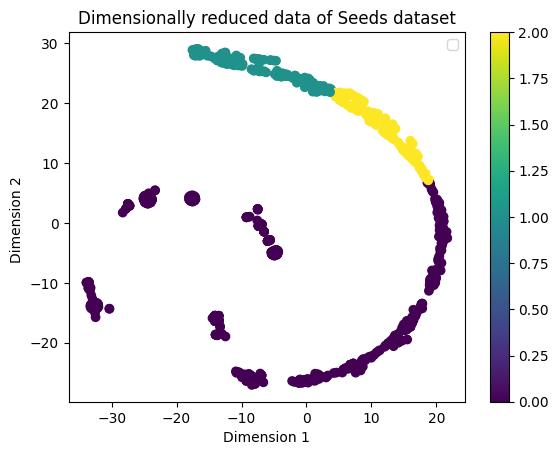

In [49]:
tsne = TSNE(n_components=2, init='random', random_state=501)
X_tsne = tsne.fit_transform(embeddings)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=assignments, cmap='viridis')
#plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', label='Cluster Centers')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2 ')
plt.title("Dimensionally reduced data of MNIST dataset")
plt.legend()
plt.colorbar()
plt.savefig("../figures/mnist.png")